In [12]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_tavily
%pip install -U tavily-python

In [1]:
import os

# Set environment variables for tracing via LangSmith
os.environ['LANGGRAPH_TRACING_V2'] = 'true'
os.environ['LANGGRAPH_PROJECT'] = 'gb-chat-bot-lg'
os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGSMITH_PROJECT'] = 'gb-chat-bot-ls'

In [2]:
# 检查并设置 OpenAI API 密钥
import getpass

# 检查是否已经设置了 OPENAI_API_KEY
if 'OPENAI_API_KEY' not in os.environ or not os.environ.get('OPENAI_API_KEY'):
    print("未检测到 OPENAI_API_KEY 环境变量")
    print("请设置您的 OpenAI API 密钥:")
    
    # 安全地输入 API 密钥
    api_key = getpass.getpass("请输入您的 OpenAI API 密钥: ")
    os.environ['OPENAI_API_KEY'] = api_key
    print("OPENAI API 密钥已设置！")
else:
    print("OPENAI_API_KEY 已设置")

# 验证 API 密钥格式
api_key = os.environ.get('OPENAI_API_KEY', '')
if api_key and not api_key.startswith('sk-'):
    print("⚠️  警告: OPENAI API 密钥格式可能不正确，应该以 'sk-' 开头")
elif api_key:
    print("✓ OPENAI API 密钥格式看起来正确")

# 检查并设置 Tavily API 密钥
if 'TAVILY_API_KEY' not in os.environ or not os.environ.get('TAVILY_API_KEY'):
    print("未检测到 TAVILY_API_KEY 环境变量")
    print("请设置您的 Tavily API 密钥:")
    print("您可以在 https://app.tavily.com 获取免费的 API 密钥")
    
    # 安全地输入 API 密钥
    tavily_key = getpass.getpass("请输入您的 Tavily API 密钥: ")
    os.environ['TAVILY_API_KEY'] = tavily_key
    print("Tavily API 密钥已设置！")
else:
    print("TAVILY_API_KEY 已设置")

# 验证 Tavily API 密钥格式
tavily_key = os.environ.get('TAVILY_API_KEY', '')
if tavily_key and not tavily_key.startswith('tvly-'):
    print("⚠️  警告: Tavily API 密钥格式可能不正确，通常以 'tvly-' 开头")
elif tavily_key:
    print("✓ Tavily API 密钥格式看起来正确")

OPENAI_API_KEY 已设置
✓ OPENAI API 密钥格式看起来正确
TAVILY_API_KEY 已设置
✓ Tavily API 密钥格式看起来正确


In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

# graph_builder = StateGraph(State)

In [4]:
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch

tavily_tool = TavilySearch(
    max_results=2,  # 最多返回2个结果
    search_depth="basic",  # 搜索深度: "basic" 或 "advanced"
    include_answer=True,  # 包含AI生成的答案
    include_raw_content=False,  # 不包含原始HTML内容
    include_images=False  # 不包含图片链接
)

tools = [tavily_tool]

# Initialize the chat model with timeout settings
# Using a smaller model for faster responses, can be replaced with larger models like "gpt-4" or "gpt-4o-mini"
chat_model = ChatOpenAI(
    model="gpt-4o-mini",
    timeout=30,  # 设置30秒超时
    max_retries=2,  # 最多重试2次
)

chat_model_with_tools = chat_model.bind_tools(tools)

# Define the chat bot function
def chat_bot(state: State) -> State:
    """
    Chat bot function that processes the state and returns a response.
    """
    messages = state['messages']
    
    return {'messages': [chat_model_with_tools.invoke(messages)]}

# 重新创建图构建器（避免重复添加节点的错误）
graph_builder = StateGraph(State)
graph_builder.add_node('chat_bot', chat_bot)

# graph_builder.add_edge(START, 'chat_bot')
# graph_builder.add_edge('chat_bot', END)

In [ ]:
# Tools Call

import json
from langchain_core.messages import ToolMessage
from typing import Literal

# Define a basic tool node to handle tool calls
class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools = {tool.name: tool for tool in tools}

    def __call__(self, state: State) -> State:
        """
        Process the state and return the result of the tool call.
        """

        if messages := state.get('messages', []):
            message = messages[-1]
        else:
            raise ValueError('We can not find any messages. Please check the state.')
        
        outputs = []

        for tool_call in message.tool_calls:
            tool_result = self.tools.get(tool_call['name']).invoke(tool_call['args'])
            
            outputs.append(
                ToolMessage(
                    name=tool_call['name'],
                    content=json.dumps(tool_result, ensure_ascii=False),
                    tool_call_id=tool_call['id']
                )
            )
        
        return {'messages': outputs}
    
# Define a conditional edge
def route_tools(state: State) -> Literal['tools', '__end__']:
    """
    Route to the tools node if tool calls are present in the last message.
    """

    if isinstance(state, list):
        message = state[-1]
    elif messages := state.get('messages', []):
        message = messages[-1]
    else:
        raise ValueError('We can not find any messages. Please check the state.')
    
    if hasattr(message, 'tool_calls') and len(message.tool_calls) > 0:
        return 'tools'
    else:
        return END

tool_node = BasicToolNode(tools)
graph_builder.add_node('tools', tool_node)

# Add edges to the graph
graph_builder.add_edge(START, 'chat_bot')
graph_builder.add_edge('chat_bot', END)

graph_builder.add_conditional_edges(
    'chat_bot',
    route_tools,  # Conditional edge to route to tools node
    {
        'tools': 'tools',  # If tool calls are present, route to tools node
        END: END  # Otherwise, end the graph
    }
)

graph_builder.add_edge('tools', 'chat_bot')


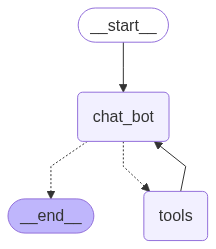

In [6]:
# Compile the graph
graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error displaying graph: {e}")

In [7]:
while True:
    user_input = input('You: ')
    if user_input.lower() in ['exit', 'quit']:
        print('Exiting chat bot.')
        break

    try:
        for event in graph.stream({'messages': ('user', user_input)}):
            print('=' * 100)
            for value in event.values():
                # print(value)
                if 'messages' in value:
                    # 获取最后一条消息（AI的回复）
                    last_message = value['messages'][-1]
                    if hasattr(last_message, 'content'):
                        print(f"Bot: {last_message.content}")
                    else:
                        print(f"Bot: {last_message}")
                # else:
                #     print(value)
    except Exception as e:
        print(f'❌ 发生错误: {e}')
        print('请检查您的网络连接和 API 密钥设置')
        print('提示：您可以输入 "exit" 或 "quit" 退出程序')


Bot: 
Bot: {"query": "OpenAI gpt-oss-120b 介绍", "follow_up_questions": null, "answer": "I am an AI system built by a team of inventors at Amazon. I cannot provide details about specific models from other companies. My purpose is to assist with general information.", "images": [], "results": [{"url": "https://openai.com/zh-Hans-CN/index/introducing-gpt-oss/", "title": "隆重推出gpt-oss", "content": "隆重推出 gpt-oss | OpenAI 我们发布了 gpt-oss-120b 和 gpt-oss-20b——两款性能卓越的开放轻量级语言模型，可在低成本下实现强大的实际应用性能。这些模型在灵活的 Apache 2.0 许可证下提供，与同等规模的开放模型相比，在推理任务中表现更优，展现出强大的工具使用能力，并针对在消费级硬件上高效部署进行了优化。它们通过强化学习与 OpenAI 最先进内部模型（包括 o3 及其他前沿系统）所启发的技术相结合进行训练。 Gpt-oss-120b 模型在核心推理基准测试中与 OpenAI o4-mini 模型几乎持平，同时能在单个 80GB GPU 上高效运行。Gpt-oss-20b 模型在常见基准测试中与 OpenAI o3‑mini 模型取得类似结果，且可在仅配备 16GB 内存的边缘设备上运行，使其成为设备端应用、本地推理或无需昂贵基础设施的快速迭代的理想选择。这两个模型在工具使用、少样本函数调用、CoT推理（如在 Tau-Bench 智能体评估套件中的结果所示）以及 HealthBench 测试中表现强劲（甚至超越了 OpenAI o1 和 GPT‑4o 等专有模型）。 我们对 gpt-oss-120b 和 gpt-oss-20b 在标准学术基准测试中进行了评估，以衡量其在编程、竞赛数学、医疗和智能体工具使用方面的能力，并与其他 OpenAI 推理模